### HW 1: Streaming Large Text     
    - Catherine Nguyen
    - Updated: 02/22/2021
    - stat196k
    
## Background

The [GDELT Project](https://www.gdeltproject.org/) is the Global Database of Events, Language, and Tone.
It describes itself as:

> A Global Database of Society.
> Supported by Google Jigsaw, the GDELT Project monitors the world's broadcast, print, and web news from nearly every corner of every country in over 100 languages and identifies the people, locations, organizations, themes, sources, emotions, counts, quotes, images and events driving our global society every second of every day, creating a free open platform for computing on the entire world.

The events from 2018 are available in a single file at the S3 URI `s3://stat196k-data-examples/2018.csv.gz`.
This file is 3.8 GB, compressed.
Here are the [column definitions](https://stat196k-data-examples.s3.amazonaws.com/GDELT_2.0_Events_Column_Labels_Header_Row_Sep2016.csv).


### Goldstein Score

> Each CAMEO event code is assigned a numeric score from -10 to +10, capturing the theoretical potential impact that type of event will have on the stability of a country.
> This is known as the Goldstein Scale.
> This field specifies the Goldstein score for each event type.
> NOTE: this score is based on the type of event, not the specifics of the actual event record being recorded‚ thus two riots, one with 10 people and one with 10,000, will both receive the same Goldstein score.
> This can be aggregated to various levels of time resolution to yield an approximation of the stability of a location over time.

I believe this is the [CAMEO event code mapping](http://eventdata.parusanalytics.com/cameo.dir/CAMEO.SCALE.txt) to goldstein scores.

## Assignment

Turn in two files:

- A PDF or HTML document containing your answers to the following questions in a neatly organized report.
- A file with extension `.sh.txt` showing all the code necessary to reproduce your work.
    The `.sh` is for shell script, and this is normally the only extension you need.
    The `.txt` allows Canvas to render it as plain text in the web browser, so I can grade it.

I suggest you use markdown through something like pandoc, Rmarkdown, or Jupyter notebooks to create your report.
The [markdown source for the assignment](https://raw.githubusercontent.com/clarkfitzg/csus_website/master/_posts/2021-02-05-homework-streaming-large-text-file.md) is on Github, so you can copy and paste from there.
MS Word and other GUI programs should work fine too.

In [4]:
#prepping the dataset we downloaded from ec2 and bring in all our imports
import pandas as pd
import numpy as np
df = pd.read_csv("C:/Users/hlcn2/Desktop/Stats196k-notebooks/first100rows.csv") 
df.head()

,GLOBALEVENTID,SQLDATE,MonthYear,Year,FractionDate,Actor1Code,Actor1Name,Actor1CountryCode,Actor1KnownGroupCode,Actor1EthnicCode,...,DATEADDED,SOURCEURL,Unnamed: 61,Unnamed: 62,Unnamed: 63,Unnamed: 64,Unnamed: 65,Unnamed: 66,Unnamed: 67,Unnamed: 68
0,719024869,20170101,201701,2017,2017.0027,AGR,FARMER,NaN,NaN,NaN,...,2.018010e+13,http://www.kansas.com/news/business/article192...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,719024870,20170101,201701,2017,2017.0027,AGR,FARMER,NaN,NaN,NaN,...,2.018010e+13,http://www.kansas.com/news/business/article192...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,719024871,20170101,201701,2017,2017.0027,AGR,FARMER,NaN,NaN,NaN,...,2.018010e+13,http://www.kansas.com/news/business/article192...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,719024872,20170101,201701,2017,2017.0027,AGR,FARMER,NaN,NaN,NaN,...,2.018010e+13,http://www.kansas.com/news/business/article192...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,719024873,20170101,201701,2017,2017.0027,AGR,FARMER,NaN,NaN,NaN,...,2.018010e+13,http://www.kansas.com/news/business/article192...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
#the unnamed columns are not needed so I am removing them from DataFrame df
df = df[['GLOBALEVENTID', 'SQLDATE', 'MonthYear', 'Year', 'FractionDate',
       'Actor1Code', 'Actor1Name', 'Actor1CountryCode', 'Actor1KnownGroupCode',
       'Actor1EthnicCode', 'Actor1Religion1Code', 'Actor1Religion2Code',
       'Actor1Type1Code', 'Actor1Type2Code', 'Actor1Type3Code', 'Actor2Code',
       'Actor2Name', 'Actor2CountryCode', 'Actor2KnownGroupCode',
       'Actor2EthnicCode', 'Actor2Religion1Code', 'Actor2Religion2Code',
       'Actor2Type1Code', 'Actor2Type2Code', 'Actor2Type3Code', 'IsRootEvent',
       'EventCode', 'EventBaseCode', 'EventRootCode', 'QuadClass',
       'GoldsteinScale', 'NumMentions', 'NumSources', 'NumArticles', 'AvgTone',
       'Actor1Geo_Type', 'Actor1Geo_FullName', 'Actor1Geo_CountryCode',
       'Actor1Geo_ADM1Code', 'Actor1Geo_ADM2Code', 'Actor1Geo_Lat',
       'Actor1Geo_Long', 'Actor1Geo_FeatureID', 'Actor2Geo_Type',
       'Actor2Geo_FullName', 'Actor2Geo_CountryCode', 'Actor2Geo_ADM1Code',
       'Actor2Geo_ADM2Code', 'Actor2Geo_Lat', 'Actor2Geo_Long',
       'Actor2Geo_FeatureID', 'ActionGeo_Type', 'ActionGeo_FullName',
       'ActionGeo_CountryCode', 'ActionGeo_ADM1Code', 'ActionGeo_ADM2Code',
       'ActionGeo_Lat', 'ActionGeo_Long', 'ActionGeo_FeatureID', 'DATEADDED',
       'SOURCEURL']]
df.head()

,GLOBALEVENTID,SQLDATE,MonthYear,Year,FractionDate,Actor1Code,Actor1Name,Actor1CountryCode,Actor1KnownGroupCode,Actor1EthnicCode,...,ActionGeo_Type,ActionGeo_FullName,ActionGeo_CountryCode,ActionGeo_ADM1Code,ActionGeo_ADM2Code,ActionGeo_Lat,ActionGeo_Long,ActionGeo_FeatureID,DATEADDED,SOURCEURL
0,719024869,20170101,201701,2017,2017.0027,AGR,FARMER,NaN,NaN,NaN,...,2,Minnesota United States,US,USMN,NaN,45.7326,-93.9196,MN,2.018010e+13,http://www.kansas.com/news/business/article192...
1,719024870,20170101,201701,2017,2017.0027,AGR,FARMER,NaN,NaN,NaN,...,1,Mexico,MX,MX,NaN,23.0000,-102.0000,MX,2.018010e+13,http://www.kansas.com/news/business/article192...
2,719024871,20170101,201701,2017,2017.0027,AGR,FARMER,NaN,NaN,NaN,...,1,Mexico,MX,MX,NaN,23.0000,-102.0000,MX,2.018010e+13,http://www.kansas.com/news/business/article192...
3,719024872,20170101,201701,2017,2017.0027,AGR,FARMER,NaN,NaN,NaN,...,2,Minnesota United States,US,USMN,NaN,45.7326,-93.9196,MN,2.018010e+13,http://www.kansas.com/news/business/article192...
4,719024873,20170101,201701,2017,2017.0027,AGR,FARMER,NaN,NaN,NaN,...,1,Mexico,MX,MX,NaN,23.0000,-102.0000,MX,2.018010e+13,http://www.kansas.com/news/business/article192...


Straight out from downloading this onto my local machine this data was a mess. Shown above is the cleaned up version. 

## Questions

### 1 - subset

_5 pts_

Download a small subset of the data (100 rows is plenty) to your personal computer, and examine it using any software you like.
Briefly describe this subset of the data by picking out a couple rows that look interesting to you.

1. How many columns are there?

In [11]:
#This shows all the columns in the dataframe and their names
df.columns

Index(['GLOBALEVENTID', 'SQLDATE', 'MonthYear', 'Year', 'FractionDate',
       'Actor1Code', 'Actor1Name', 'Actor1CountryCode', 'Actor1KnownGroupCode',
       'Actor1EthnicCode', 'Actor1Religion1Code', 'Actor1Religion2Code',
       'Actor1Type1Code', 'Actor1Type2Code', 'Actor1Type3Code', 'Actor2Code',
       'Actor2Name', 'Actor2CountryCode', 'Actor2KnownGroupCode',
       'Actor2EthnicCode', 'Actor2Religion1Code', 'Actor2Religion2Code',
       'Actor2Type1Code', 'Actor2Type2Code', 'Actor2Type3Code', 'IsRootEvent',
       'EventCode', 'EventBaseCode', 'EventRootCode', 'QuadClass',
       'GoldsteinScale', 'NumMentions', 'NumSources', 'NumArticles', 'AvgTone',
       'Actor1Geo_Type', 'Actor1Geo_FullName', 'Actor1Geo_CountryCode',
       'Actor1Geo_ADM1Code', 'Actor1Geo_ADM2Code', 'Actor1Geo_Lat',
       'Actor1Geo_Long', 'Actor1Geo_FeatureID', 'Actor2Geo_Type',
       'Actor2Geo_FullName', 'Actor2Geo_CountryCode', 'Actor2Geo_ADM1Code',
       'Actor2Geo_ADM2Code', 'Actor2Geo_Lat', 'Act

In [12]:
#This shows us the shape of the dataframe and there are 100 rows and 61 columns. 
df.shape

(100, 61)

2. Do the data values in each column seem to match the column definitions?

In [14]:
# Prior to cleaning the data is was very difficult to tell whether they matched the columns from the Gdelt excel file
# but after cleaning the data up is does seem to fit the columns. However the data types may be off but i can always 
# reformat it if needed. 
df.tail(3)

,GLOBALEVENTID,SQLDATE,MonthYear,Year,FractionDate,Actor1Code,Actor1Name,Actor1CountryCode,Actor1KnownGroupCode,Actor1EthnicCode,...,ActionGeo_Type,ActionGeo_FullName,ActionGeo_CountryCode,ActionGeo_ADM1Code,ActionGeo_ADM2Code,ActionGeo_Lat,ActionGeo_Long,ActionGeo_FeatureID,DATEADDED,SOURCEURL
97,719024966,20180101,201801,2018,2018.0027,NaN,NaN,NaN,NaN,NaN,...,3,Castle Rock Colorado United States,US,USCO,NaN,39.3722,-104.856,169449,2.018010e+13,http://www.sthelensstar.co.uk/news/national/15...
98,719024967,20180101,201801,2018,2018.0027,NaN,NaN,NaN,NaN,NaN,...,3,Douglas County Colorado United States,US,USCO,NaN,39.3333,-104.951,198133,2.018010e+13,http://spokanepublicradio.org/post/1-officer-d...
99,719024968,20180101,201801,2018,2018.0027,NaN,NaN,NaN,NaN,NaN,...,3,Highlands Ranch Colorado United States,US,USCO,NaN,39.5539,-104.969,1867085,2.018010e+13,http://www.theboneonline.com/news/authorities-...


3. What character delimits the records?

* The delimiter for this record was a '/t'. Also known as tab. Which was a pain to clean up, but thats the fun in cleaning data. 

4. What is the CAMEO event code, what event does this correspond to, and what is the Goldstein score?

In [63]:
#The CAMEO event code seems to be held in the columns called 'EventCode' however in gdelt excel it states that this 
# is the raw CAMEO action code so lets take a peak at this column. So to get a better picture i decided to show
# columns 'IsRootEvent', 'EventCode', 'EventBaseCode','EventRootCode','QuadClass','GoldsteinScale'
EventCodes = df[['IsRootEvent','EventCode','EventBaseCode','EventRootCode','QuadClass','GoldsteinScale']]
EventCodes.sample(5)

,IsRootEvent,EventCode,EventBaseCode,EventRootCode,QuadClass,GoldsteinScale
53,0,61,61,6,2,6.4
11,1,42,42,4,1,1.9
73,0,90,90,9,2,-2.0
12,1,42,42,4,1,1.9
45,1,190,190,19,4,-10.0


Based on the sample above. All the Event codes are held in the 'EventCode' column. 'EventBaseCode' is the same as the 'EventCode' and the 'EventRootCode' takes the all but the last digit of the 'EventCode', the root so to speak. The Codes correspond to the action the actor takes. Which the impact of this action on the stablity of the country is then scored, this score is in the 'GoldsteinScale'. Below we'll take a closer look at these scores.

In [36]:
# Based on GDELT these scores range from [-10 to 10] as a float data type. Below I have made another datframe
# GoldsteinScore and displayed all the unique scores in the 100 rows.
GoldsteinScore = df['GoldsteinScale']
GoldsteinScore.unique()

array([  6.4,  -4.4,   2.8,  -5. ,   1.9,  -8. ,   3. ,  -2. ,   0. ,
         3.4,   5. ,  -9.2, -10. ,   4. ,   1. ,   7. ,   8. ,  -0.4,
        -4. ,   0.4])

In [40]:
GoldsteinScore.dtype

dtype('float64')

5. Are the URL's to the news articles still live, and do they match the CAMEO event code?

In [70]:
#Made another dataframe to look at these 3 specific columns. Then sampled 4 rows out of the 100 to check. 
Urls=df[['EventCode', 'QuadClass', 'SOURCEURL', 'GoldsteinScale']]
Urls.sample(4)

,EventCode,QuadClass,SOURCEURL,GoldsteinScale
85,193,4,http://www.theboneonline.com/news/authorities-...,-10.0
51,36,1,http://blogs.timesofisrael.com/the-importance-...,4.0
8,130,3,http://www.heraldsun.com.au/news/victoria/thre...,-4.4
46,61,2,https://www.kuenselonline.com/bafra-seizes-ban...,6.4


'The numeric codes in this field map to the Quad Classes as follows: 1=Verbal Cooperation, 2=Material Cooperation, 3=Verbal Conflict, 4=Material Conflict.' We will use this to determine whether the URL match the event code.


In [74]:
#Row 96, event code 190, Quad class 4(Material Conflict)
Urls.iloc[85]['SOURCEURL'] # Dead URl
#'http://www.theboneonline.com/news/authorities-multiple-deputies-down-after-shooting-denver-suburb/MQTKxt64RC4tg76WTOIzDK/'

Urls.iloc[51]['SOURCEURL'] # Dead URL
#'http://blogs.timesofisrael.com/the-importance-of-social-responsibility-forging-a-new-connection-between-making-money-and-making-a-difference/'

Urls.iloc[8]['SOURCEURL'] # Live URL
#'http://www.heraldsun.com.au/news/victoria/three-men-burnt-while-using-illegal-fireworks-to-bring-in-2018/news-story/3f19242cc5fda5181931965d81fc1626?nk=0a819496d71c943b20ea7f7092959275-1514764002'

Urls.iloc[46]['SOURCEURL'] # Live URL
#'https://www.kuenselonline.com/bafra-seizes-banned-vegetable/'

'https://www.kuenselonline.com/bafra-seizes-banned-vegetable/'

Based on the sample above only 2 of the 4 have live urls. Which are rows 8 and 46. Which respectively have a quad class of 3 and 2 and score of -4.4 and 6.4. Based on this sample, I will imply that quad classes of 1 and 2 have positive goldstein score. While quad class 3 and 4 have negative goldstein scores. Also the event codes seem to match. Row 8 has quad class 3 for verbal conflict, not obeying warning. Whereas, rows 46 is material cooperation of banned veggies. 

6. Does the Goldstein score appear to be doing what it was designed to do?

In [75]:
EventCodes.sample(10)

,IsRootEvent,EventCode,EventBaseCode,EventRootCode,QuadClass,GoldsteinScale
15,0,42,42,4,1,1.9
0,1,61,61,6,2,6.4
28,0,42,42,4,1,1.9
31,0,42,42,4,1,1.9
72,0,90,90,9,2,-2.0
74,1,172,172,17,4,-5.0
26,0,10,10,1,1,0.0
41,1,80,80,8,2,5.0
63,1,20,20,2,1,3.0
58,1,100,100,10,3,-5.0


Based on this brief analysis, I would say that the goldstein score is doing what it was meant to do. However, there are some Quad class 2's that bear a negative Goldstein Score and contradicts the previous claim.  

### 2 - histogram

_10 pts_

Create a histogram of the Goldstein scores for all of 2018, using the integers as bin endpoints for the histogram.
It's possible to do this in less than 10 minutes using a single shell pipeline on a t2 micro instance with 1 vCPU, 1 GiB memory, and 8 GiB storage.

1. How long does your program take to run?

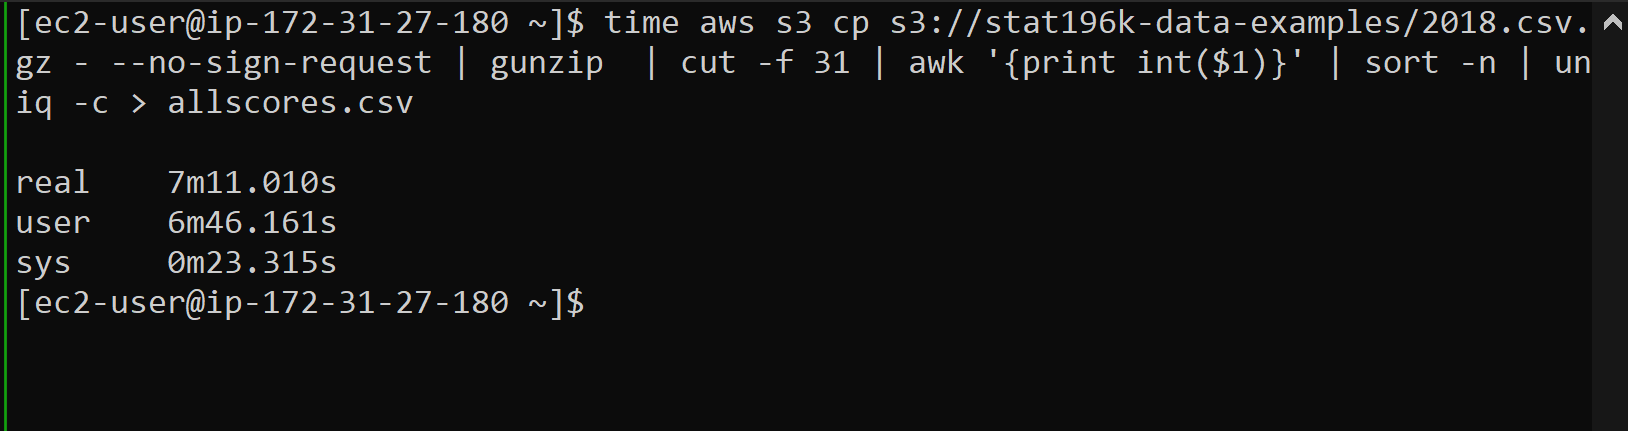

In [79]:
from IPython import display 
display.Image("time.PNG")

2. Explain in detail what each command in the pipeline does and how they work together.

**time aws s3 cp s3://stat196k-data-examples/2018.csv.gz - --no-sign-request | gunzip  | cut -f 31 | awk '{print int($1)}'** **|sort -n | uniq -c > allscores.csv**

time = will output the time it takes to run your pipeline/command. You want to put time before your commands.

aws s3 cp = lets up copy/download a file from a aws s3 object. In this case an aws s3 object and were accessing the professors bucket/object "s3://stat196l....2018/csv.gz" 

s3://....gz = is the pathway of the bucket and file we wanted to download. 

--no-sign-request = lets us access the file without having to check our credentials.

gunzip = lets us unzip a gzip/.gz files. Similar to extracting a compressed/sipped file on a Windows device. 

cut -f 31 = this cuts the file by the 31st column cause based on the gdelt file we know the goldstein scores are in the 31st column. -f refers to fields which is similar to columns. 

awk '{print int($1)}' =By default, awk considers a field to be a string of characters surrounded by whitespace, the start of a line, or the end of a line. Fields are identified by a dollar sign ($) and a number. So, $1 represents the first field, which we’ll use with the print action to print the first field. 

sort -n = sort the input based on the numerical value. 

uniq -c = this filters out the lines, keeping all values that are unique. So no dupes.

3. Plot and interpret the histogram.
    You'll probably want to download the summary statistics (around 20 numbers) to your personal computer to plot the histogram.
    Do you notice anything strange?

In [90]:
scores= pd.read_csv('C:/Users/hlcn2/Desktop/Stats196k-notebooks/allscores.csv')
scores

,Count,GoldsteinScore
0,3574463,-10
1,1388564,-9
2,126350,-8
3,580378,-7
4,501636,-6
5,4013554,-5
6,2279054,-4
7,5600655,-2
8,8502587,0
9,8619617,1


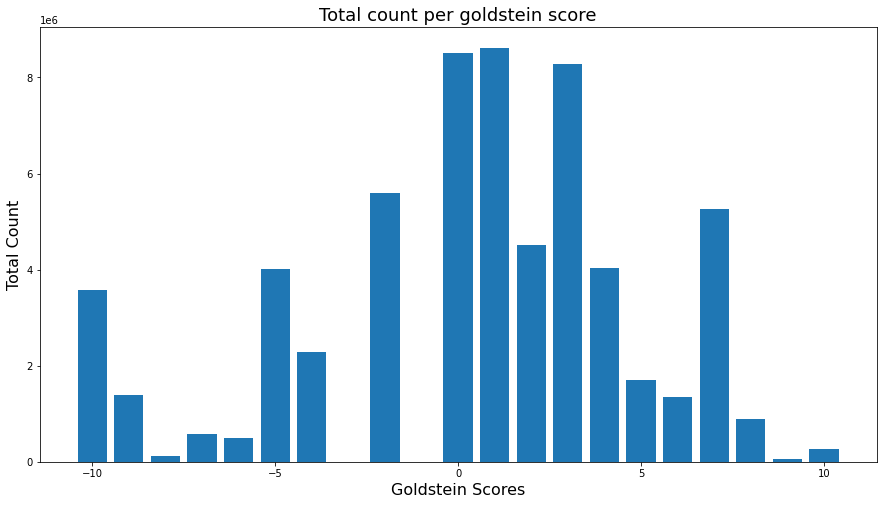

In [120]:
import matplotlib.pyplot as plt

x = scores['GoldsteinScore']
y = scores['Count']

plt.figure(figsize=(15,8))
plt.bar(x,y)
#plt.xlim(-10, 10)
plt.title('Total count per goldstein score', fontsize=18)
plt.xlabel('Goldstein Scores', fontsize=16)
plt.ylabel('Total Count', fontsize=16)

plt.show()

Based on this graph, you will notice that there are visually more positive scores than there are negative scores, but there are more -10s than there are 10s. Suprisingly, the mode seems to be the those with a score of 1 and 0 being the runner up. Also, the strange thing about this data is there are no scores with -1 and -3. This could possibly be an error or a flaw in the goldstein scores. The inability to determine what deserves a score or -1 or -3. 

4. Exactly how many events (rows) are in this data?

To determine the total number of rows in the data we can sum up all the counts per score. 

In [119]:
# There is a total of 61,544,481 events/rows in this dataset. 
scores['Count'].sum()

61544481

### 3 - performance

_5 pts_

Print and interpret the output of `top` while your program is running.

1. What are the bottlenecks?

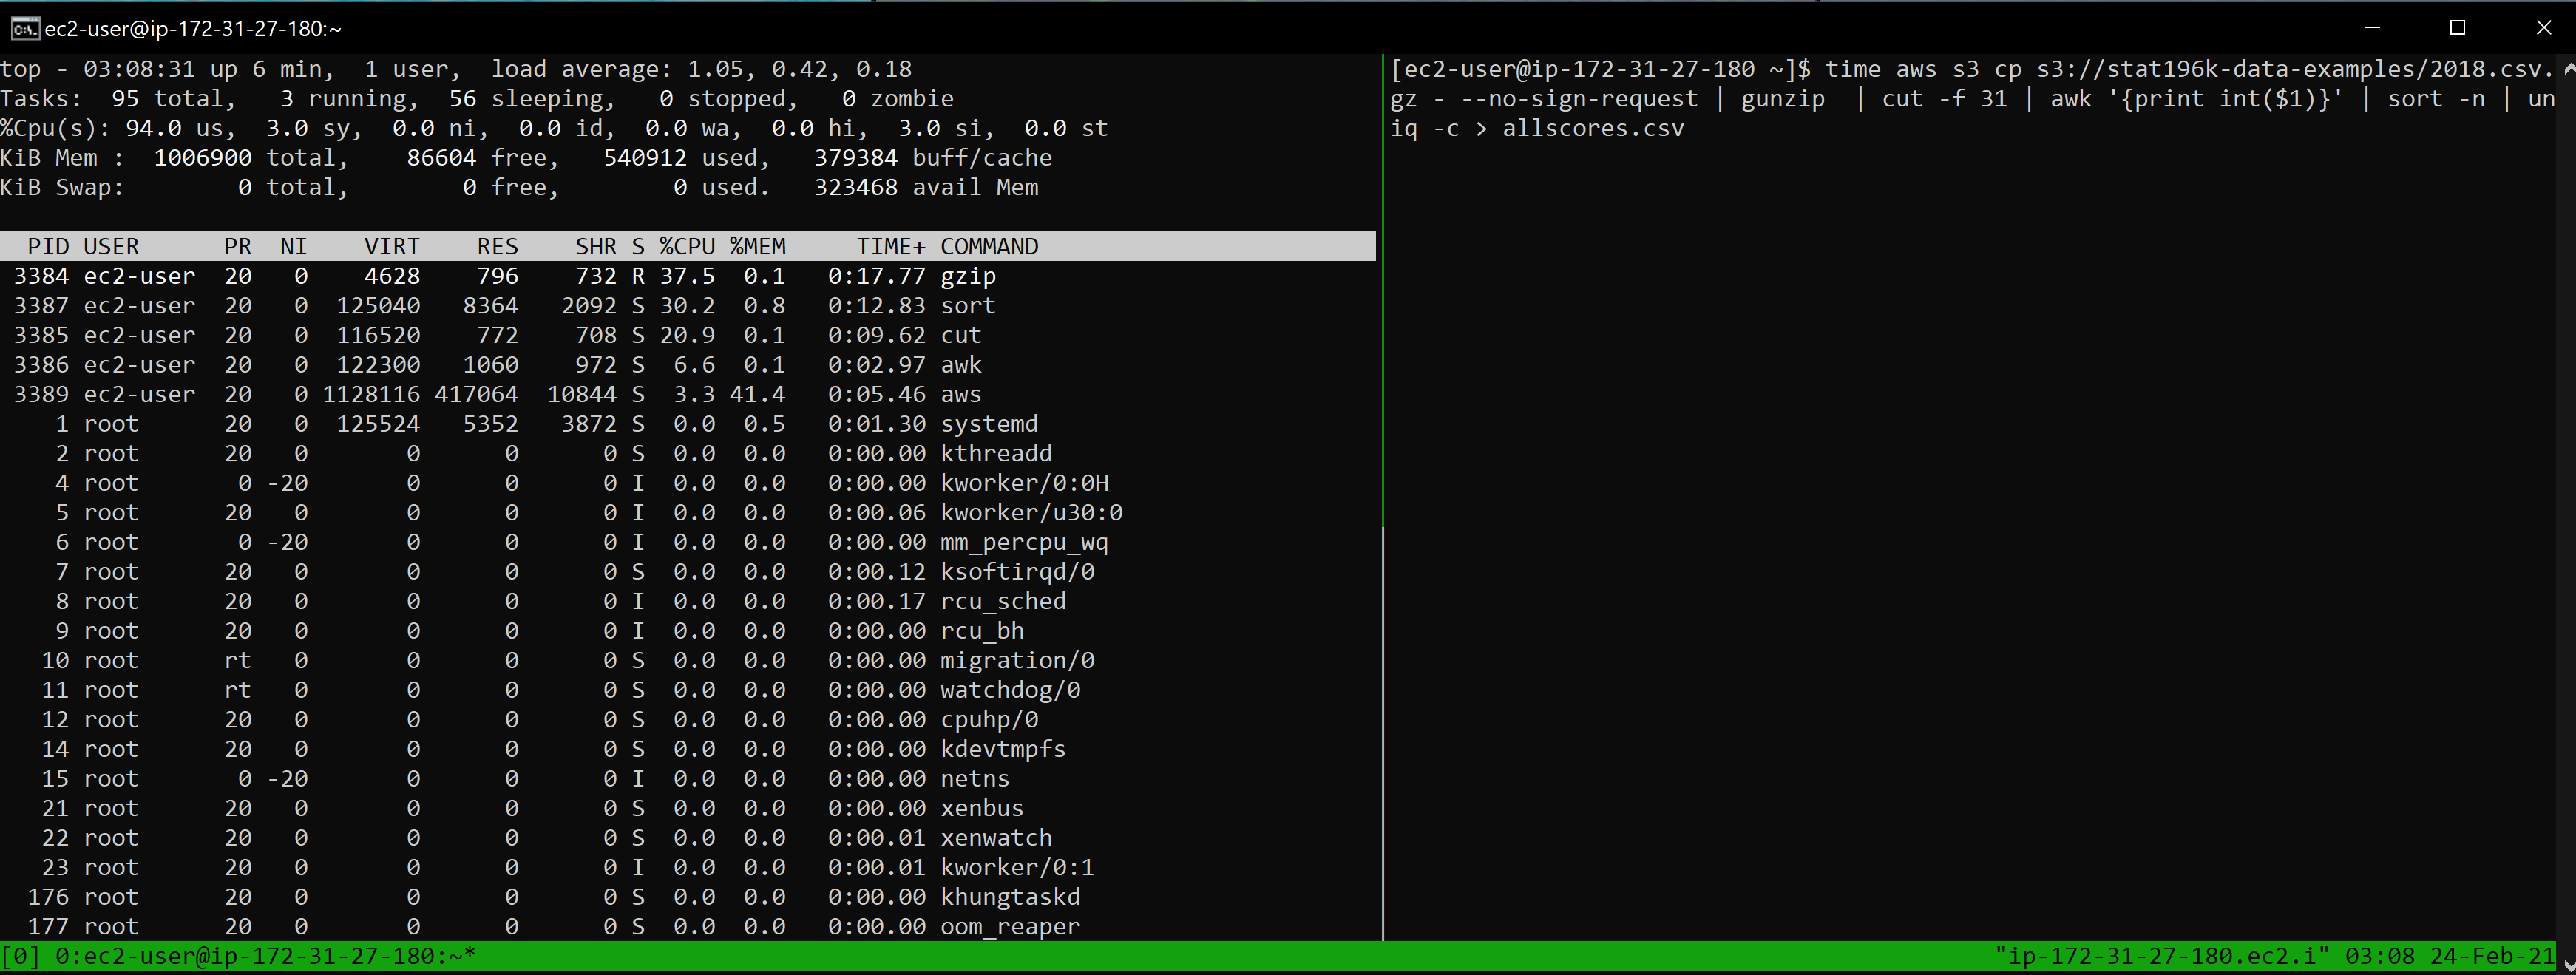

In [76]:
display.Image("beep.PNG")

Based on the screenshot I took early on, it looks like gzip, sort, and cut are the bottlenecks. Mostly the gzip because it takes up the cpu the most and its in bold and has the longest Time+. 

2. Run and time your program on an EC2 instance with more vCPU's and a faster network and show the results of `top` once more.
    Is the program faster on the more expensive instance?

For this I will use the `t2.2xlarge` instance type to compare, with 8 vCPU and 32 GiB. 

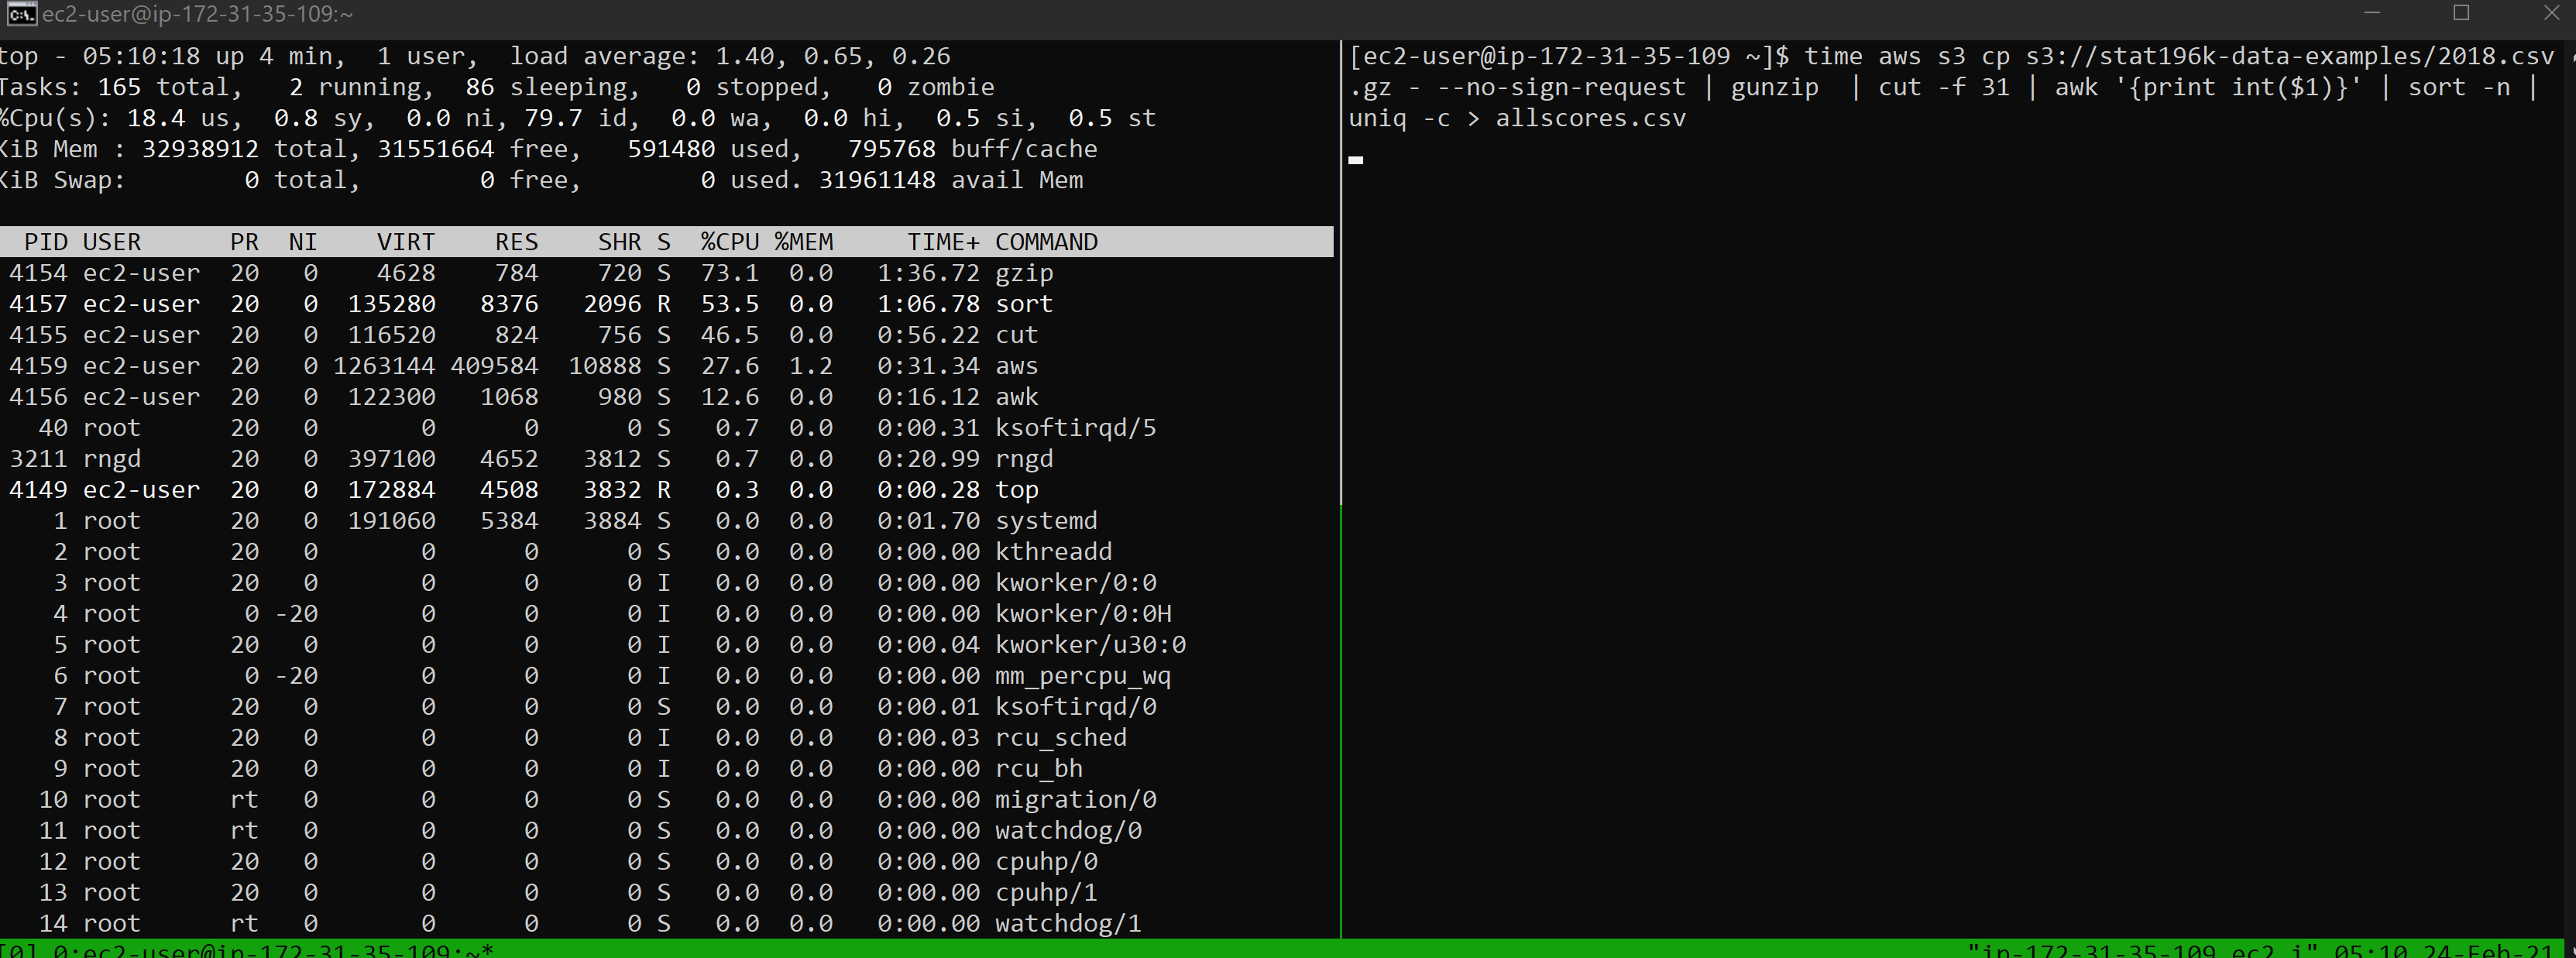

In [125]:
display.Image("boom.PNG")

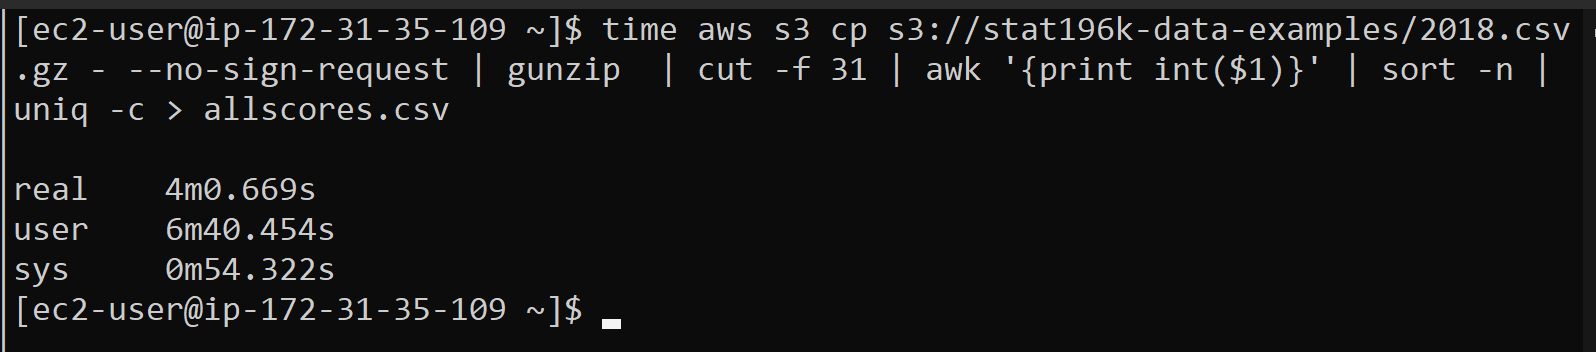

In [126]:
display.Image("tim.PNG")

In conclusion, yes. The program is faster on a more expensive instance. Here it takes roughly 4 minutes and previously on the other instance it took 7 minutes and 11 seconds. 

3. Are you benefitting from pipeline parallelism?

Yes, we can run multiple commands in a pipe and at the same time run top to check the bottlenecks. In other words, it is convenient to be able ti multitask. 

4. What's the bottleneck now?


gzip, sort, and cut this time around. Gzip taking longer than sort and sort being longer than cut. Somewhat different from the other instances's run. 

5. Compare and comment on the financial cost of using a more expensive instance versus the t2.micro.
    Is it worth it?

Instance 1: (real)7mins11s, (user)6min46s, (sys)23s. Instance 2(expensive): 4min, 6min40s, 54s.  
In terms of speed it could be worth it. You can get the file downloaded in half the time it took in the cheaper instance. However what I find interesting is the user and sys times are identical. In fact the sys time on the expensive instance is the double the time of the cheaper instance. In other words, if you are in a hurry and need it downloded now the expensive instance may be worth it, but as someone that is already impressed by the download speed of the cheap version. I do not find it worth it. 

__Remember to terminate these more expensive machines immediately after you use them!__
Otherwise, you may quickly run through your $50 credit and have to spend your own money.
[AWS Services Supported](https://s3.amazonaws.com/awseducate-starter-account-services/AWS_Educate_Starter_Accounts_and_AWS_Services.pdf) says that our Educate accounts can only use these kinds of instances: "t2.small", "t2.micro", "t2.nano", "m4.large", "c4.large", "c5.large", "m5.large", "t2.medium", "m4.xlarge", "c4.xlarge", "c5.xlarge", "t2.2xlarge", "m5.2xlarge", "t2.large", "t2.xlarge", "m5.xlarge".

### 4 - Extra Credit Challenge

_0 pts, optional_

Starting with the same 3.8 GB file on S3, calculate the summary statistics necessary for the histogram as fast as possible.
You can use the shell or any other programming language together with any EC2 instance available through your AWS Educate account.
Hint: look into software like [GNU parallel](https://www.gnu.org/software/parallel/) and [pigz](http://zlib.net/pigz/).
Turn in any extra code you write.
The student with the fastest program gets a minimal amount of extra credit and a maximal amount of glory.